In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE, chi2, VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from feature_engine.selection import DropCorrelatedFeatures
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, plot_confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from neural_network import get_CV_prediction, build_model
import math
import random
import KNN
import decisionTree
import logisticRegression

In [2]:
def loadData(path):
    return pd.DataFrame(pd.read_csv(path))

def dropDuplicatedRowAndColumn(train, test):   
    train = train.drop_duplicates()
    drop = train.columns.duplicated()
    return [train.loc[:,~drop], test.loc[:,~drop[:len(drop)-1]]]

def quasiConstantRemoval(train, threshold, test):
    constant_filter = VarianceThreshold(threshold= threshold)
    constant_filter.fit(train)
    return [pd.DataFrame(constant_filter.transform(train)),pd.DataFrame(constant_filter.transform(test))]

def dropCorrelatedFeatures(train,test):
    drop_correlated = DropCorrelatedFeatures(
    variables=None, method='pearson', threshold=0.9)
    drop_correlated.fit(train)
    return [pd.DataFrame(drop_correlated.transform(train)),pd.DataFrame(drop_correlated.transform(test))]

def featureSelectionANOVA(train_X, train_Y, test, numOfFeatures):
    fvalue_best = SelectKBest(f_classif, k=numOfFeatures)
    fvalue_best.fit(train_X, train_Y)
    return [pd.DataFrame(fvalue_best.transform(train_X)),pd.DataFrame(fvalue_best.transform(test))]
    
def featureSelectionRFE(train_X, train_Y, test, numOfFeatures, estimator):
    rfe = RFE(estimator = estimator, n_features_to_select=numOfFeatures)
    rfe.fit(train_X, train_Y)
    return [pd.DataFrame(rfe.transform(train_X)),pd.DataFrame(rfe.transform(test))]

def featureSelectionCHI2(train_X, train_Y, test, numOfFeatures):
    new_best = SelectKBest(chi2, k=numOfFeatures)
    new_best.fit(train_X, train_Y)
    return [pd.DataFrame(new_best.transform(train_X)),pd.DataFrame(new_best.transform(test))]

def dropColumnWithName(data, name):
    column_to_drop = [c for c in data if c.startswith(name)]
    data = data.drop(columns = column_to_drop )

def normalise(data):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(data))

In [3]:
def evaluate_model(model, X_test, Y_test, model_name):
    if (model_name == 'Neural Network'):
        prediction = model.predict_proba(X_test).ravel()
    else :
        prediction = model.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, threshold1 = roc_curve(Y_test, prediction)
    print('roc_auc_score for ', model_name,': ', roc_auc_score(Y_test, prediction))

    plt.title('ROC - ' + model_name)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('images/evaluate_model_score.png', bbox_inches='tight')
    if(model_name != 'Neural Network'):
        plot_confusion_matrix(model, X_test, Y_test)
        plt.savefig('images/evaluate_model_confusionMatrix.png', bbox_inches='tight')

In [4]:
# reading the CSV files
df_train = loadData("train.csv")
df_test = loadData("test.csv")

# dropping "ID" from both training and test data
ID_train = df_train["ID"].copy()
ID_test = df_test["ID"].copy()
df_train = df_train.drop(columns = "ID")
df_test = df_test.drop(columns = "ID")

dup = dropDuplicatedRowAndColumn(df_train, df_test)
df_train = dup[0]
df_test = dup[1]

df_train_y = df_train['TARGET'].copy()
df_train_x = df_train.drop(columns="TARGET")

In [16]:
## ---------------------------------------------data preprocess---------------------------------

In [5]:
quasi_res = quasiConstantRemoval(df_train_x, 0.01, df_test)
df_train_x = quasi_res[0]
df_test = quasi_res[1]

correlated  = dropCorrelatedFeatures(df_train_x,df_test)
df_train_x = correlated[0]
df_test = correlated[1]

In [ ]:
## --------------------------------------------feature selection------------------------------

In [7]:
# use ANOVA to select k best features
num_features_ANOVA = 100
df_train_x, df_test = featureSelectionANOVA(df_train_x, df_train_y, df_test, num_features_ANOVA)

# use decisionTreeClassifier for the estimator of RFE to fun the feature selection
estimator = DecisionTreeClassifier()
num_features_RFE = 70
df_train_x, df_test = featureSelectionRFE(df_train_x, df_train_y, df_test, num_features_RFE, estimator)

df_train_x = normalise(df_train_x)
df_train_y = np.ravel(df_train_y)
df_test = normalise(df_test)



In [8]:
 ## ---------------------------------------------------------------- split data -----------------------------------
# split data into train set, validation set and test set as 2:1:1
X_train, X_test, Y_train, Y_test = train_test_split(df_train_x, df_train_y, test_size = 0.5)

X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5)

roc_auc_score:  0.7124356670096927   number of neighbours:  20
roc_auc_score:  0.7438155253755337   number of neighbours:  40
roc_auc_score:  0.7501098135162547   number of neighbours:  60
roc_auc_score:  0.7603436313038373   number of neighbours:  80
roc_auc_score:  0.7681013794563047   number of neighbours:  100
roc_auc_score:  0.769061341409728   number of neighbours:  120
roc_auc_score:  0.7701918388247857   number of neighbours:  140
roc_auc_score:  0.7713695810398973   number of neighbours:  160
roc_auc_score:  0.7718062927506406   number of neighbours:  180
roc_auc_score:  0.7731057502792658   number of neighbours:  200
roc_auc_score:  0.7744903832464166   number of neighbours:  220
roc_auc_score:  0.7740877516486576   number of neighbours:  240
roc_auc_score:  0.7748581100882703   number of neighbours:  260
roc_auc_score:  0.7758456822169321   number of neighbours:  280
roc_auc_score:  0.776008796815226   number of neighbours:  300
roc_auc_score:  0.7755489252616282   number of

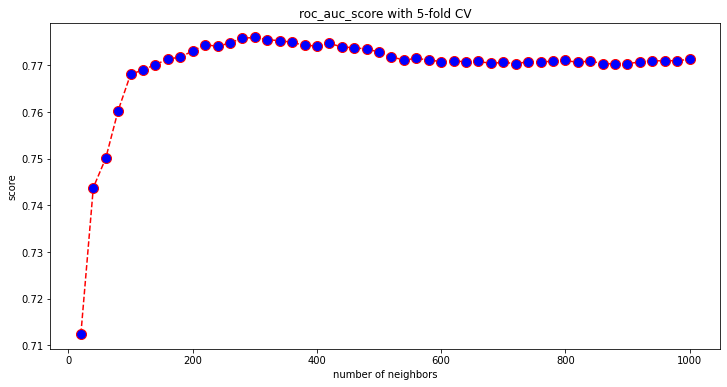

accuracy:  0.6544421292389224   depth:  1
accuracy:  0.7691075796059543   depth:  2
accuracy:  0.7950007257834878   depth:  3
accuracy:  0.802307705330793   depth:  4
accuracy:  0.8087719307885651   depth:  5
accuracy:  0.7794625705715443   depth:  6
accuracy:  0.7643521298913429   depth:  7
accuracy:  0.7509450788614156   depth:  8
accuracy:  0.7378452430942135   depth:  9
accuracy:  0.7301174440444775   depth:  10
accuracy:  0.7256180681849864   depth:  11
accuracy:  0.7200116157125622   depth:  12
accuracy:  0.7103446781285536   depth:  13
accuracy:  0.700840005066019   depth:  14
accuracy:  0.6913240300106426   depth:  15
accuracy:  0.6857485639608567   depth:  16
accuracy:  0.6758152920629004   depth:  17
accuracy:  0.6673212697198567   depth:  18
accuracy:  0.6575571613499763   depth:  19
accuracy:  0.6525601344249142   depth:  20
accuracy:  0.6492429879133189   depth:  21
accuracy:  0.6396995742107265   depth:  22
accuracy:  0.6350049290577212   depth:  23
accuracy:  0.626287175

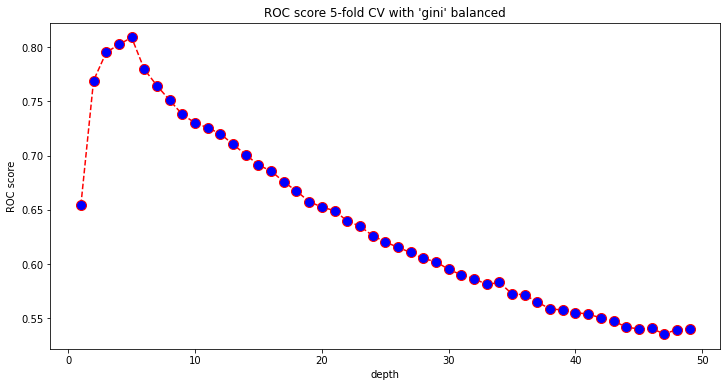

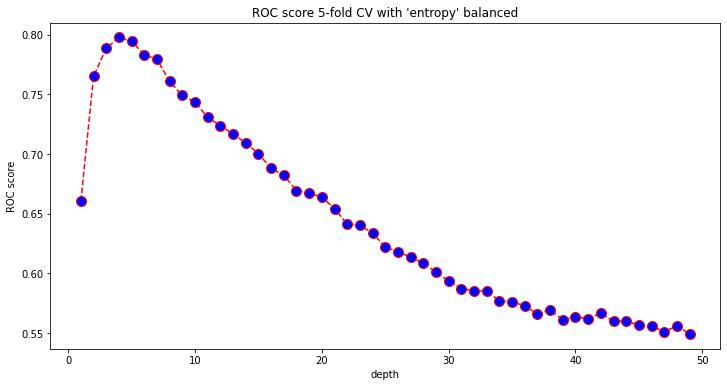

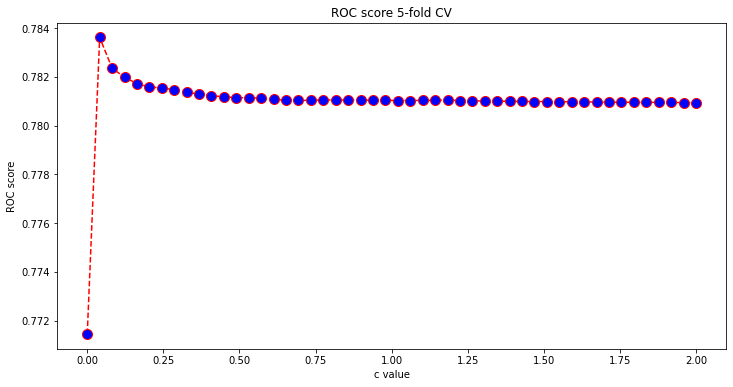

In [9]:
KNN.K_value_tuning(X_val, Y_val)
decisionTree.depth_tuning(X_val, Y_val)
logisticRegression.c_value_tuning(X_val, Y_val)

In [10]:
# KNN model
knn = KNeighborsClassifier(n_neighbors=250, weights='distance')
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=250, weights='distance')

In [11]:
# decision tree model
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', criterion='entropy')
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5)

In [12]:
# logistic regression model
lgr = LogisticRegression(C=0.05, class_weight='balanced', solver='liblinear')
lgr.fit(X_train, Y_train)

LogisticRegression(C=0.05, class_weight='balanced', solver='liblinear')

In [13]:
# neural network model
nn = build_model(X_train.shape[1], 167,0.001,0.0)
nn.fit(X_train, Y_train, epochs=20, batch_size=10000)

Epoch 1/20
4/4 [==============================] - 20s 31ms/step - loss: 0.6410 - accuracy: 0.7677
Epoch 2/20
4/4 [==============================] - 0s 29ms/step - loss: 0.4510 - accuracy: 0.9603
Epoch 3/20
4/4 [==============================] - 0s 31ms/step - loss: 0.3165 - accuracy: 0.9602
Epoch 4/20
4/4 [==============================] - 0s 26ms/step - loss: 0.2196 - accuracy: 0.9607
Epoch 5/20
4/4 [==============================] - 0s 28ms/step - loss: 0.1764 - accuracy: 0.9605
Epoch 6/20
4/4 [==============================] - 0s 39ms/step - loss: 0.1680 - accuracy: 0.9604
Epoch 7/20
4/4 [==============================] - 0s 25ms/step - loss: 0.1634 - accuracy: 0.9611
Epoch 8/20
4/4 [==============================] - 0s 24ms/step - loss: 0.1594 - accuracy: 0.9608
Epoch 9/20
4/4 [==============================] - 0s 27ms/step - loss: 0.1561 - accuracy: 0.9608
Epoch 10/20
4/4 [==============================] - 0s 28ms/step - loss: 0.1548 - accuracy: 0.9600
Epoch 11/20
4/4 [===========

roc_auc_score for  knn :  0.7713736460460026
roc_auc_score for  decision tree :  0.8139696154968827
roc_auc_score for  logistic regression :  0.7944500205688829


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


roc_auc_score for  Neural Network :  0.7845641140654313


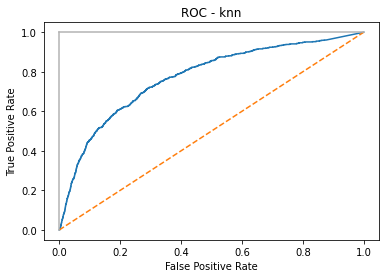

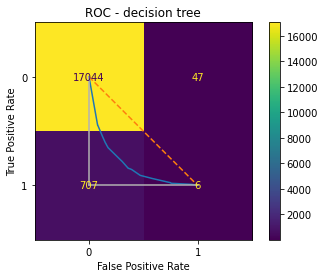

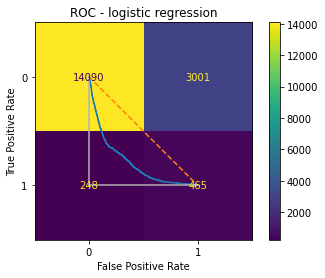

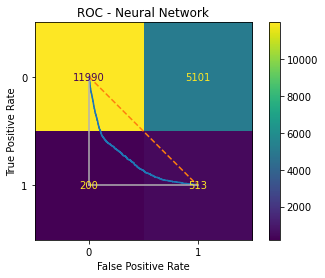

In [14]:
## -----------------------------------------model analysis --------------------------------

roc_auc_score for  decision tree :  0.8139696154968827


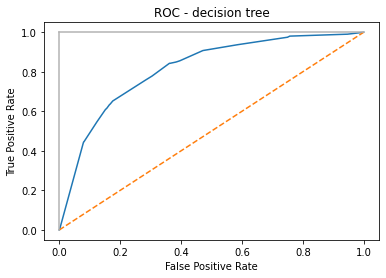

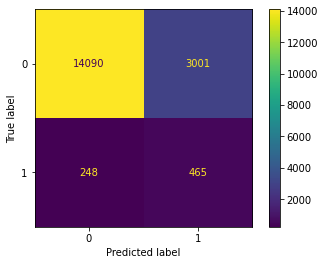

In [15]:
evaluate_model(dt, X_test, Y_test, 'decision tree')

roc_auc_score for  knn :  0.7713736460460026


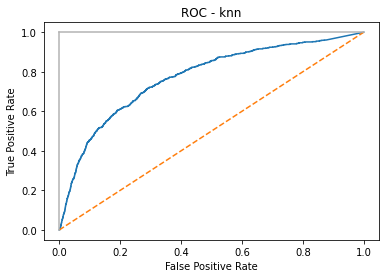

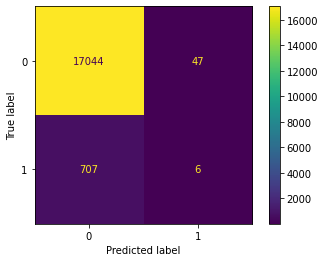

In [17]:
evaluate_model(knn, X_test, Y_test, 'knn')


roc_auc_score for  logistic regression :  0.7944500205688829


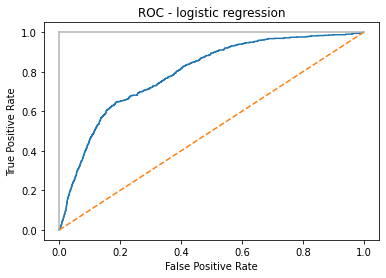

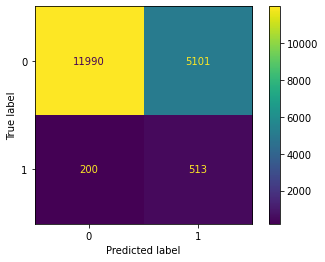

In [18]:
evaluate_model(lgr, X_test, Y_test, 'logistic regression')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


roc_auc_score for  Neural Network :  0.7845641140654313


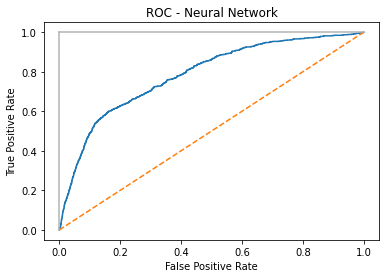

In [19]:
evaluate_model(nn, X_test, Y_test, 'Neural Network')

In [ ]:
 ## --------------------------------------------------assemble models -----------------------------------

In [20]:
knn_prediction = knn.predict_proba(df_test)[:,1]

In [21]:
dt_prediction = dt.predict_proba(df_test)[:,1]

In [22]:
lgr_prediction = lgr.predict_proba(df_test)[:,1]

In [ ]:
nn_prediction = get_CV_prediction(df_train_x,df_train_y,{"lr":0.001,"dropout_rate":0},df_test,167)

0.001 0 167
Epoch 1/20
7/7 [==============================] - 2s 22ms/step - loss: 0.6594 - accuracy: 0.5935
Epoch 2/20
7/7 [==============================] - 0s 24ms/step - loss: 0.3447 - accuracy: 0.9607
Epoch 3/20
7/7 [==============================] - 0s 24ms/step - loss: 0.1997 - accuracy: 0.9601
Epoch 4/20
7/7 [==============================] - 0s 28ms/step - loss: 0.1689 - accuracy: 0.9603
Epoch 5/20
7/7 [==============================] - 0s 22ms/step - loss: 0.1617 - accuracy: 0.9600
Epoch 6/20
7/7 [==============================] - 0s 22ms/step - loss: 0.1531 - accuracy: 0.9609
Epoch 7/20
7/7 [==============================] - 0s 22ms/step - loss: 0.1531 - accuracy: 0.9602
Epoch 8/20
7/7 [==============================] - 0s 40ms/step - loss: 0.1494 - accuracy: 0.9607
Epoch 9/20
7/7 [==============================] - 0s 33ms/step - loss: 0.1456 - accuracy: 0.9609
Epoch 10/20
7/7 [==============================] - 0s 33ms/step - loss: 0.1454 - accuracy: 0.9608
Epoch 11/20
7/7 [

7/7 [==============================] - 0s 24ms/step - loss: 0.1297 - accuracy: 0.9606
Epoch 5/20
7/7 [==============================] - 0s 21ms/step - loss: 0.1296 - accuracy: 0.9607
Epoch 6/20
7/7 [==============================] - 0s 25ms/step - loss: 0.1296 - accuracy: 0.9606
Epoch 7/20
7/7 [==============================] - 0s 23ms/step - loss: 0.1291 - accuracy: 0.9606
Epoch 8/20
7/7 [==============================] - 0s 21ms/step - loss: 0.1289 - accuracy: 0.9607
Epoch 9/20
7/7 [==============================] - 0s 23ms/step - loss: 0.1285 - accuracy: 0.9608
Epoch 10/20
7/7 [==============================] - 0s 21ms/step - loss: 0.1284 - accuracy: 0.9608
Epoch 11/20
7/7 [==============================] - 0s 21ms/step - loss: 0.1282 - accuracy: 0.9607
Epoch 12/20
7/7 [==============================] - 0s 31ms/step - loss: 0.1282 - accuracy: 0.9609
Epoch 13/20
7/7 [==============================] - 0s 29ms/step - loss: 0.1282 - accuracy: 0.9609
Epoch 14/20
7/7 [====================

In [ ]:
target = knn_prediction * 0.25 + dt_prediction * 0.25 + lgr_prediction * 0.25 + nn_prediction * 0.25

In [ ]:
submission = loadData('sample_submission.csv')
submission['TARGET'] = target
submission.to_csv('submission_final.csv', index=False)